Used https://www.kaggle.com/praveenmaripeti/wids-datathon-2021-challenge-eda-model-submission as the starting notebook

# Problem Overview

This challenge is hosted by WiDS Datathon Committee. It focuses on patient health, with an emphasis on the chronic condition of diabetes, through data from MIT’s GOSSIS (Global Open Source Severity of Illness Score) initiative.

**Background**

Getting a rapid understanding of the context of a patient’s overall health has been particularly important during the COVID-19 pandemic as healthcare workers around the world struggle with hospitals overloaded by patients in critical condition. Intensive Care Units (ICUs) often lack verified medical histories for incoming patients. A patient in distress or a patient who is brought in confused or unresponsive may not be able to provide information about chronic conditions such as heart disease, injuries, or diabetes. Medical records may take days to transfer, especially for a patient from another medical provider or system. Knowledge about chronic conditions such as diabetes can inform clinical decisions about patient care and ultimately improve patient outcomes.

**Overview**

In this challenge, participants are required to build a model to determine whether a patient admitted to an ICU has been diagnosed with a particular type of diabetes, Diabetes Mellitus.

**Install dabl which stands for Data Analysis Baseline library. Dabl can be used to automate many of the tasks related to data exploration and analysis**

# Import Libraries

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd

#import dabl
#from pandas_profiling import ProfileReport #For generating profile reports

import matplotlib.pyplot as plt  #data visualization
import seaborn as sns
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

from sklearn.experimental import enable_iterative_imputer   # For imputing missing values
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix  #metrics
from scipy import stats

import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Needs libxgboost.dylib : brew install libomp

import warnings
warnings.filterwarnings('ignore')  #silence warnings

### CONSTANTS

In [2]:
DATA_FOLDER = "data" #"../input/widsdatathon2021"

CAT_COLUMNS = {
    "demographic1" : ['age', 'gender', 'ethnicity', 'weight', 'height', 'bmi'], 
    "demographic2" : ['elective_surgery', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type','icu_type',           
    'pre_icu_los_days'], 
    "apache_covariate" : ['albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis',
       'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache',
       'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',
       'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache',
       'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache',
       'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache'],
    "apache_comorbidity" : ['aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis', 'diabetes_mellitus'
       ],
    "vitals_d1" : ['d1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max',
       'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max',
       'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
       'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min',
       'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
       'd1_temp_max', 'd1_temp_min'],
    "vitals_h1" : ['h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max',
       'h1_diasbp_min', 'h1_diasbp_noninvasive_max',
       'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min',
       'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max',
       'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
       'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min',
       'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 'h1_sysbp_max',
       'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
       'h1_temp_max', 'h1_temp_min'],
    "labs_d1" :['d1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max',
       'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max',
       'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min',
       'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min',
       'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max',
       'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max',
       'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min',
       'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max',
       'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min'],
    "labs_h1" : ['h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max',
       'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max',
       'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min',
       'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min',
       'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max',
       'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max',
       'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min',
       'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max',
       'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min'], 
    "labs_blood_gas" : ['d1_arterial_pco2_max',
       'd1_arterial_pco2_min', 'd1_arterial_ph_max', 'd1_arterial_ph_min',
       'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_pao2fio2ratio_max',
       'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max', 'h1_arterial_pco2_min',
       'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_arterial_po2_max',
       'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min']
}

DEFAULT_COLOR = '#812878'

CAT_COLORS = {  'demographic1':  '#812878',                             
                'demographic2':  '#B0B3D6',
                'apache_covariate': '#2C2255',
                'apache_comorbidity': '#4B8BBE',
                'vitals_d1':  '#CC2336', 
                'vitals_h1': '#FFE873',
                'labs_d1': '#E4682A', 
                'labs_h1': '#FFD43B', 
                'labs_blood_gas': '#F69824'
                }

### COMMON FUNCTIONS

In [3]:
def getColor(col):
    for cat in CAT_COLUMNS.keys():
        if col in CAT_COLUMNS[cat]: 
            return CAT_COLORS.get(cat, '#333333')

def missingData(df):
    print(df.shape)
    missing_cnt = df.isna().sum() #column wise sum of missing values
    if missing_cnt.sum() == 0:
        print("There are no missing values")
        return pd.DataFrame()

    #display only the columns with missing values with count and proportion of missing values by column 
    missing_df = pd.concat([missing_cnt.rename('Missing Count'), 
                            missing_cnt.div(len(df)/100).rename('Missing Ratio')], axis=1).loc[missing_cnt.ne(0)]
    missing_df = missing_df.reset_index().rename(columns={'index': 'Feature'})
    missing_df['Filled Ratio'] = missing_df['Missing Ratio'].apply(lambda x: 100-x)
    print(missing_df)
    COLORS=[getColor(col) for col in missing_df['Feature'].values]
    print(missing_df.columns)
    #print(COLORS)
    missing_df.plot.bar(x='Feature', y='Filled Ratio', title="Filled data", figsize=(18,6), fontsize=7, color=COLORS)
    return missing_df

def printDFDetails(df):
    print(f"Shape: {df.shape}; Null values: {pd.DataFrame(df).isna().sum().sum()}\nColumns: {df.columns} \nColumns of object type: {df.select_dtypes('object').columns}")
    
def printDFGroups(df, cols):
    for col in cols:
        print(df.groupby(by=col)[col].agg(['count']))

def nanRows(df):
    return f"{df.isnull().any(axis=1).sum()}, {(df.isnull().any(axis=1).sum()/df.shape[0])*100:0.2f}%"


In [4]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

    def inverse_transform(self, data_list):
        return self.label_encoder.inverse_transform(data_list)

def labelEncode(df, col):
    df[col] = df[col].astype('str')
    
    print(f"{col} Before LE: {df_5_knn[col].unique()}")
    
    df[col] = df[col].fillna(np.nan) 
    df_original = df[col]
    df_mask = df[col].isnull()

    #df[col] = df[[col]].apply(LabelEncoder().fit_transform)
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])

    df[col] = df[col].where(~df_mask, df_original)
    #print(df[col])
    return df, le

In [5]:
simple_encoders = {}

# impute string values using SimpleImputer with 'most_frequent' strategy
def imputeSimple(df_train, df_unlabeled, cols):
    simple_imp = SimpleImputer(strategy='most_frequent')

    print(f"Unique values: ", end=" ")
    [print(f"{col} {df_train[col].unique()}", end=" ") for col in cols]; print()
    for col in cols:
        #le1 = LabelEncoder()
        #le = LabelEncoderExt()
        
        #le.fit(df_train[col])
        #print(f'{col} le.classes_: {le.classes_}')
        #simple_encoders[col] = le

        # fill missing values with np.nan
        df_train[col] = df_train[col].fillna(np.nan) 
        df_unlabeled[col] = df_unlabeled[col].fillna(np.nan) 
       
        simple_imp.fit(df_train[col].values.reshape(-1,1))

        df_train[col] = simple_imp.transform(df_train[col].values.reshape(-1,1))
        df_train[col] = df_train[col].astype('str') # convert data to string type
        #df_train[col] = le.transform(df_train[col])

        df_unlabeled[col] = simple_imp.transform(df_unlabeled[col].values.reshape(-1,1))
        df_unlabeled[col] = df_unlabeled[col].astype('str')
        #df_unlabeled[col] = le.transform(df_unlabeled[col])
    [print(f"{col} {df_train[col].unique()}", end=" ") for col in cols]; print()
    return df_train, df_unlabeled

# Impute numerical values
def imputeIterative(df_train, df_unlabeled, unlabeled=False):
    tic = datetime.now()
    iter_imp = IterativeImputer(random_state=0) # instantiate IterativeImputer

    iter_imp.fit(df_train) # fit and transform the data
    
    df_train_new = iter_imp.fit_transform(df_train) # fit and transform the data
    df_train_new = pd.DataFrame(df_train_new, columns=df_train.columns)

    df_unlabeled_new = pd.DataFrame()
    if unlabeled == True:
        df_unlabeled_new = iter_imp.fit_transform(df_unlabeled) # fit and transform the data
        df_unlabeled_new = pd.DataFrame(df_unlabeled_new, columns=df_unlabeled.columns)

    toc = datetime.now()
    print(f"IterativeImputer took {toc-tic}sec")
    return df_train_new, df_unlabeled_new

xgb = XGBClassifier(n_estimators=400, colsample_bytree=0.7, reg_lambda=120, subsample=0.75) #parameters 

'''
Computes roc auc score as the score will computed for several datasets. 
- It will split the training set into a sub training set (80%) and test set(20%). 
- A simple XGBClassifier will be trained on the sub training set, evaluated on test set.
- Finally the function prints roc auc score on full training set and the original test set.
'''
def compute_roc_auc(train_set, target):
    tic = datetime.now()
    X_train, X_test, y_train, y_test = train_test_split(train_set, target, test_size=0.2, random_state=42)
    xgb.fit(X_train, y_train)
    y_test_pred = xgb.predict(X_test)
    y_train_pred = xgb.predict(X_train)
    print('train auc',roc_auc_score(y_train, y_train_pred))
    print('test auc',roc_auc_score(y_test, y_test_pred)) 
    toc = datetime.now()
    print("Time taken:", toc-tic)  

def add_features(lower_limit, upper_limit, df, missing_df, df_to_merge):
    df_ = df[missing_df[(missing_df['Missing Ratio']>=lower_limit) & (missing_df['Missing Ratio']<upper_limit)].index]
    df_new = pd.concat([pd.DataFrame(df_to_merge), df_], axis=1) # concatenate new table with existing table
    df_new = df_new.select_dtypes(include=['int', 'float']) # exclude columns with string datatype, if any
    df_new_ = imputeIterative(df_new,pd.DataFrame()) #iter_imp.fit_transform(df_new)
    df_new_ = pd.DataFrame(df_new_, columns=df_new.columns) # return table with column names intact
    return df_new_

In [6]:
df = pd.read_csv(f"{DATA_FOLDER}/TrainingWiDS2021.csv")
test = pd.read_csv(f"{DATA_FOLDER}/UnlabeledWiDS2021.csv")
ddic = pd.read_csv(f"{DATA_FOLDER}/DataDictionaryWiDS2021.csv")

# Load data

In [7]:
labs=ddic.index[(ddic['Category']=='labs')]
df.iloc[:,labs-1].columns

Index(['h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max',
       'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max',
       'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min',
       'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min',
       'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max',
       'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max',
       'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min',
       'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max',
       'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max',
       'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max',
       'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max',
       'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max',
       'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min',
       'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1

# Exploratory Data Analysis

In [8]:
df.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,...,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,...,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [9]:
test.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,1,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
1,2,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,3,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,4,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,5,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,...,NaN,NaN,NaN,0,0,0,0,0,0,0


In [10]:
print(df.shape)
print(test.shape)

(130157, 181)
(10234, 180)


In [11]:
df.describe() # summary statistics for numeric features

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
count,130157.000000,130157.000000,130157.000000,125169.000000,125667.000000,130157.000000,128080.000000,130157.000000,130157.000000,130157.0,...,16760.000000,16760.000000,130157.00000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000,130157.000000
mean,65079.000000,213000.856519,106.102131,61.995103,29.110260,0.189840,169.607219,662.428344,0.839933,0.0,...,247.525419,239.617358,0.00103,0.016081,0.013599,0.025669,0.007307,0.004187,0.020852,0.216285
std,37573.233831,38109.828146,63.482277,16.822880,8.262776,0.392176,10.833085,304.259843,2.485337,0.0,...,131.440167,128.562211,0.03207,0.125786,0.115819,0.158146,0.085166,0.064574,0.142888,0.411712
min,1.000000,147000.000000,1.000000,0.000000,14.844926,0.000000,137.200000,82.000000,-0.250000,0.0,...,42.000000,38.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32540.000000,180001.000000,49.000000,52.000000,23.598006,0.000000,162.500000,427.000000,0.045833,0.0,...,144.000000,138.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65079.000000,213014.000000,112.000000,64.000000,27.564749,0.000000,170.100000,653.000000,0.155556,0.0,...,228.125000,218.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,97618.000000,246002.000000,165.000000,75.000000,32.803127,0.000000,177.800000,969.000000,0.423611,0.0,...,333.000000,324.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,130157.000000,279000.000000,204.000000,89.000000,67.814990,1.000000,195.590000,1111.000000,175.627778,0.0,...,720.000000,654.813793,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Drop columns with all unique values or same value

In [12]:
df.drop(['Unnamed: 0'], axis=1, inplace=True) #drop columns with all unique values # , 'encounter_id', 'hospital_id', 'icu_id', 'readmission_status'

test_ids = test.pop('encounter_id')  # ids required for submission
test.drop(['Unnamed: 0'], axis=1, inplace=True) 

target = df['diabetes_mellitus']
print(df.shape)
print(test.shape)

(130157, 180)
(10234, 178)


### TODO: Drop rows with more than 80 to 90% missing data

# Missing values

The data size is quite large, it has 130157 X 181 values. Let's see how many columns have missing values in terms of percentage.

(130157, 180)
                  Feature  Missing Count  Missing Ratio  Filled Ratio
0                     age           4988       3.832295     96.167705
1                     bmi           4490       3.449680     96.550320
2               ethnicity           1587       1.219297     98.780703
3                  gender             66       0.050708     99.949292
4                  height           2077       1.595765     98.404235
..                    ...            ...            ...           ...
155    h1_arterial_ph_min         107849      82.860699     17.139301
156   h1_arterial_po2_max         107445      82.550305     17.449695
157   h1_arterial_po2_min         107445      82.550305     17.449695
158  h1_pao2fio2ratio_max         113397      87.123243     12.876757
159  h1_pao2fio2ratio_min         113397      87.123243     12.876757

[160 rows x 4 columns]
Index(['Feature', 'Missing Count', 'Missing Ratio', 'Filled Ratio'], dtype='object')


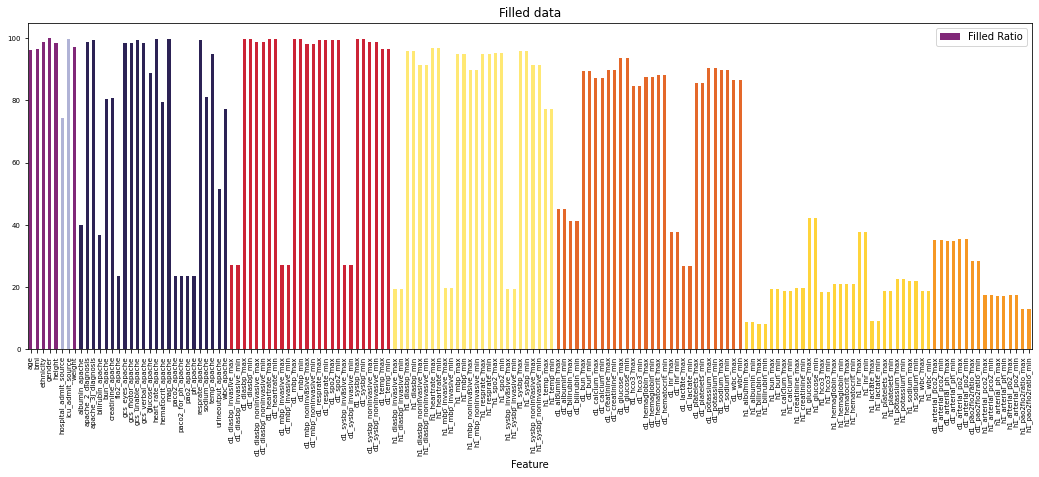

In [13]:
missing_df = missingData(df)

Out of 181 columns, 160 have missing values. The proportion of missing values in some columns is more than 80%. Clearly, missing values is a major issue with this data which needs to be fixed.

# Step 1
- identifier: Remove all
- demographic: 
    - Remove icu_id, readmission_status, bmi
    - Impute (knn) age, ethnicity, icu_stay_type, icu_type
    - Impute (knn) pre_icu_los_days
- vitals:
- labs: 
- APACHE covariate: remove all
- APACHE comorbidity: remove all
- labs blood gas: remove all


In [14]:
print(len(df.columns), df.columns.values)

180 ['encounter_id' 'hospital_id' 'age' 'bmi' 'elective_surgery' 'ethnicity'
 'gender' 'height' 'hospital_admit_source' 'icu_admit_source' 'icu_id'
 'icu_stay_type' 'icu_type' 'pre_icu_los_days' 'readmission_status'
 'weight' 'albumin_apache' 'apache_2_diagnosis' 'apache_3j_diagnosis'
 'apache_post_operative' 'arf_apache' 'bilirubin_apache' 'bun_apache'
 'creatinine_apache' 'fio2_apache' 'gcs_eyes_apache' 'gcs_motor_apache'
 'gcs_unable_apache' 'gcs_verbal_apache' 'glucose_apache'
 'heart_rate_apache' 'hematocrit_apache' 'intubated_apache' 'map_apache'
 'paco2_apache' 'paco2_for_ph_apache' 'pao2_apache' 'ph_apache'
 'resprate_apache' 'sodium_apache' 'temp_apache' 'urineoutput_apache'
 'ventilated_apache' 'wbc_apache' 'd1_diasbp_invasive_max'
 'd1_diasbp_invasive_min' 'd1_diasbp_max' 'd1_diasbp_min'
 'd1_diasbp_noninvasive_max' 'd1_diasbp_noninvasive_min'
 'd1_heartrate_max' 'd1_heartrate_min' 'd1_mbp_invasive_max'
 'd1_mbp_invasive_min' 'd1_mbp_max' 'd1_mbp_min' 'd1_mbp_noninvasive_max

## 1. Identifier variables

**STRATEGY**
Drop the identifiers

In [15]:
df_ids_ = df[['encounter_id', 'hospital_id']] 
df_ids = df_ids_.drop(columns = ['encounter_id', 'hospital_id']) #drop columns with all unique 
df_ids.shape

(130157, 0)

## 2. Demographic -1  variables

**STRATEGY**

1. IMPUTE
    - **ethnicity, gender (categorical variables)**: Encode + knn impute + Inverse Transform + Convert to dummy variables
    - **weight, height, age** (numerical variables): Knn impute
2. CONVERT AGE to age_groups and then to dummy variables

In [16]:
DEMO1_COLUMNS_TO_INCLUDE = ['age', 'ethnicity', 'gender', 'height', 'weight']  #drop derived columns (bmi)
DEMO1_CAT_COLUMNS_TO_INCLUDE = ['ethnicity', 'gender']
DEMO1_NUM_COLUMNS_TO_INCLUDE = ['height', 'weight']

In [17]:
df_demo1_ = df[DEMO1_COLUMNS_TO_INCLUDE]
df_demo1_.shape

(130157, 5)

(130157, 5)
     Feature  Missing Count  Missing Ratio  Filled Ratio
0        age           4988       3.832295     96.167705
1  ethnicity           1587       1.219297     98.780703
2     gender             66       0.050708     99.949292
3     height           2077       1.595765     98.404235
4     weight           3463       2.660633     97.339367
Index(['Feature', 'Missing Count', 'Missing Ratio', 'Filled Ratio'], dtype='object')


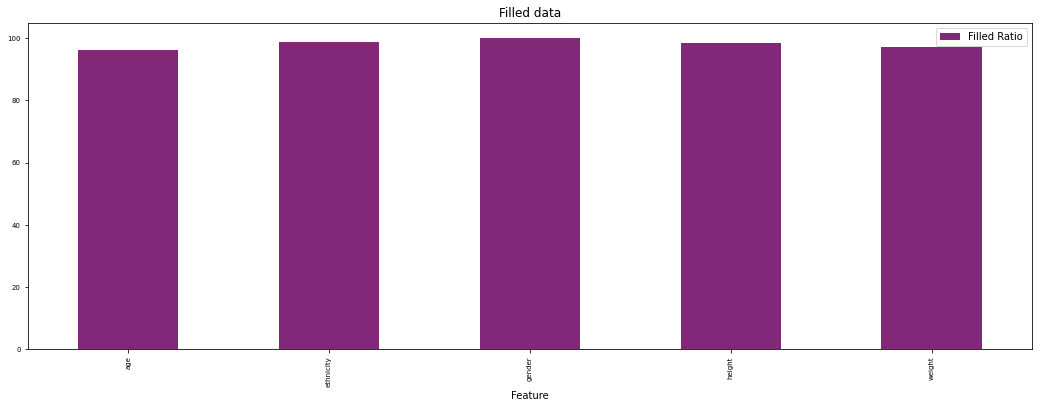

In [18]:
missing_df = missingData(df_demo1_)

In [19]:
def labelEncode(df, col):
    df[col] = df[col].fillna(np.nan) 
    print(df[col].isnull().sum(), f"{df[col].unique()}")
    df_original = df[col]
    df_mask = df[col].isnull()
    #print(df_mask.sum())

    #df[col] = df[[col]].apply(LabelEncoder().fit_transform)
    df[col] = df[col].astype('str')
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])

    df[col] = df[col].where(~df_mask)#, df_original)
    #df[col] = df[col].apply(lambda x: int(x) if not pd.isnull(x) else np.nan)
    #df[col] = df[col].astype('int')
    #print(df[col].isnull().sum(), f"{df[col].unique()}")
    return df, le

### 'ethnicity', 'gender': Encode, KNN Impute, Inverse Transform, Convert to dummy variables

In [20]:
encoders_demo1 = {}
for col in DEMO1_CAT_COLUMNS_TO_INCLUDE:
    print(f"{col} Before LE: {df_demo1_[col].unique()}")
    
    df_demo1_, le = labelEncode(df_demo1_, col)
    encoders_demo1[col] = le
    print(f"{col} After LE: {df_demo1_[col].unique()}")
    print()

ethnicity Before LE: ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']
1587 ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']
ethnicity After LE: [ 2. nan  3.  0.  1.  4.  5.]

gender Before LE: ['M' 'F' nan]
66 ['M' 'F' nan]
gender After LE: [ 1.  0. nan]



In [21]:
printDFGroups(df_demo1_, DEMO1_CAT_COLUMNS_TO_INCLUDE)
data = df_demo1_.values
ix = [i for i in range(data.shape[1])]
X = data[:, ix]

            count
ethnicity        
0.0         13911
1.0          2198
2.0        100236
3.0          5049
4.0           915
5.0          6261
        count
gender       
0.0     59573
1.0     70518


In [22]:
X.shape

(130157, 5)

In [23]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
tic = datetime.now()
np_demo1 = knn_imputer.fit_transform(X)
toc = datetime.now()
print(f"KNN Imputer {toc-tic} sec")

KNN Imputer 0:01:30.673024 sec


In [24]:
df_demo1 = pd.DataFrame(np_demo1, columns = DEMO1_COLUMNS_TO_INCLUDE)
print(df_demo1.shape, df_demo1.isna().sum().sum(), df_demo1.select_dtypes('object').columns, df_demo1.columns)

(130157, 5) 0 Index([], dtype='object') Index(['age', 'ethnicity', 'gender', 'height', 'weight'], dtype='object')


In [25]:
for col in DEMO1_CAT_COLUMNS_TO_INCLUDE:
    df_demo1[col] = df_demo1[col].astype(int)
    print(df_demo1.groupby(by=col)[col].agg(['count']))
    
print(df_demo1[DEMO1_COLUMNS_TO_INCLUDE][0:10])

            count
ethnicity        
0           13925
1            2392
2          101474
3            5190
4             915
5            6261
        count
gender       
0       59630
1       70527
    age  ethnicity  gender  height  weight
0  68.0          2       1   180.3   73.90
1  77.0          2       0   160.0   70.20
2  25.0          2       0   172.7   95.30
3  81.0          2       0   165.1   61.70
4  19.0          2       1   188.0   88.95
5  67.0          2       1   190.5  100.00
6  59.0          2       0   165.1  156.60
7  70.0          2       1   165.0  105.95
8  45.0          2       1   170.2   57.60
9  50.0          3       1   175.3   79.00


In [26]:
for col in DEMO1_CAT_COLUMNS_TO_INCLUDE:
    print(type(encoders_demo1[col]))
    df_demo1[[col]] = encoders_demo1[col].inverse_transform(df_demo1[[col]])

<class 'sklearn.preprocessing._label.LabelEncoder'>
<class 'sklearn.preprocessing._label.LabelEncoder'>


In [27]:
for col in DEMO1_CAT_COLUMNS_TO_INCLUDE:
    print(df_demo1.groupby(by=col)[col].agg(['count']))
    
print(df_demo1[DEMO1_CAT_COLUMNS_TO_INCLUDE][0:10])

                   count
ethnicity               
African American   13925
Asian               2392
Caucasian         101474
Hispanic            5190
Native American      915
Other/Unknown       6261
        count
gender       
F       59630
M       70527
   ethnicity gender
0  Caucasian      M
1  Caucasian      F
2  Caucasian      F
3  Caucasian      F
4  Caucasian      M
5  Caucasian      M
6  Caucasian      F
7  Caucasian      M
8  Caucasian      M
9   Hispanic      M


In [28]:
df_demo1 = pd.get_dummies(df_demo1, prefix = DEMO1_CAT_COLUMNS_TO_INCLUDE, drop_first=True)

In [29]:
printDFDetails(df_demo1)

Shape: (130157, 9); Null values: 0
Columns: Index(['age', 'height', 'weight', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'gender_M'],
      dtype='object') 
Columns of object type: Index([], dtype='object')


In [30]:
df_demo1

,age,height,weight,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_M
0,68.0,180.3,73.90,0,1,0,0,0,1
1,77.0,160.0,70.20,0,1,0,0,0,0
2,25.0,172.7,95.30,0,1,0,0,0,0
3,81.0,165.1,61.70,0,1,0,0,0,0
4,19.0,188.0,88.95,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
130152,50.0,175.3,90.00,0,1,0,0,0,1
130153,79.0,162.6,78.40,0,1,0,0,0,0
130154,73.0,177.8,102.00,0,0,0,0,0,1
130155,81.0,185.4,83.90,0,1,0,0,0,1


### Convert age to age groups - TODO

## 3. Demographic -2  variables

**STRATEGY**
- DROP 'icu_id', 'readmission_status' with all unique or same values
- IMPUTE using most_frequent the nan columns **hospital_admit_source, icu_admit_source** 

In [31]:
# , 
DEMO2_COLUMNS_TO_INCLUDE = ['elective_surgery', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type','pre_icu_los_days','readmission_status']
DEMO2_CAT_COLUMNS_TO_INCLUDE = ['hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']
DEMO2_NUM_COLUMNS_TO_INCLUDE = ['elective_surgery', 'pre_icu_los_days']

In [32]:
df_demo2_ = df[DEMO2_COLUMNS_TO_INCLUDE]
df_demo2_.shape

(130157, 8)

In [33]:
df_demo2_ = df_demo2_.drop(columns = ['icu_id', 'readmission_status']) #drop columns with all unique or same values
df_demo2_.shape

(130157, 6)

In [34]:
df_demo2_.isnull().sum()

elective_surgery             0
hospital_admit_source    33198
icu_admit_source           240
icu_stay_type                0
icu_type                     0
pre_icu_los_days             0
dtype: int64

In [35]:
df_demo2_['hospital_admit_source'].unique()

array(['Floor', 'Emergency Department', 'Operating Room', nan,
       'Direct Admit', 'Other Hospital', 'Other ICU', 'ICU to SDU',
       'Recovery Room', 'Chest Pain Center', 'Step-Down Unit (SDU)',
       'Acute Care/Floor', 'PACU', 'Observation', 'ICU', 'Other'],
      dtype=object)

In [36]:
df_demo2_['icu_admit_source'].unique()

array(['Floor', 'Accident & Emergency', 'Operating Room / Recovery',
       'Other Hospital', 'Other ICU', nan], dtype=object)

(130157, 6)
                 Feature  Missing Count  Missing Ratio  Filled Ratio
0  hospital_admit_source          33198      25.506120     74.493880
1       icu_admit_source            240       0.184393     99.815607
Index(['Feature', 'Missing Count', 'Missing Ratio', 'Filled Ratio'], dtype='object')


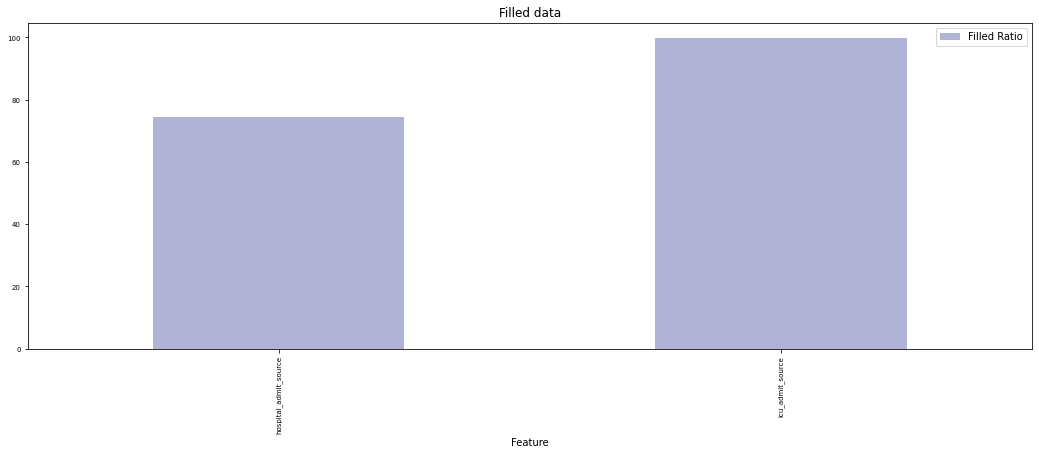

In [37]:
missing_df = missingData(df_demo2_)

In [38]:
df_demo2_.replace('?',np.NaN,inplace=True)
imp=SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
df_demo2 =pd.DataFrame(imp.fit_transform(df_demo2_))
df_demo2.columns=df_demo2_.columns
df_demo2.index=df_demo2_.index

In [39]:
df_demo2.isnull().sum()

elective_surgery         0
hospital_admit_source    0
icu_admit_source         0
icu_stay_type            0
icu_type                 0
pre_icu_los_days         0
dtype: int64

In [40]:
df_demo2[0:10]

,elective_surgery,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days
0,0,Floor,Floor,admit,CTICU,0.541667
1,0,Floor,Floor,admit,Med-Surg ICU,0.927778
2,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0.000694
3,1,Operating Room,Operating Room / Recovery,admit,CTICU,0.000694
4,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0.073611
5,0,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,0.000694
6,0,Operating Room,Accident & Emergency,admit,Med-Surg ICU,0.000694
7,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0.002083
8,0,Other Hospital,Other Hospital,admit,CCU-CTICU,0.009028
9,0,Direct Admit,Accident & Emergency,admit,CCU-CTICU,0.060417


In [41]:
df_demo = df_demo1
df_demo[df_demo2.columns] = df_demo2
print(df_demo.shape, df_demo.columns)

(130157, 15) Index(['age', 'height', 'weight', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'gender_M', 'elective_surgery',
       'hospital_admit_source', 'icu_admit_source', 'icu_stay_type',
       'icu_type', 'pre_icu_los_days'],
      dtype='object')


In [42]:
df_demo[0:10]

,age,height,weight,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_M,elective_surgery,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days
0,68.0,180.3,73.90,0,1,0,0,0,1,0,Floor,Floor,admit,CTICU,0.541667
1,77.0,160.0,70.20,0,1,0,0,0,0,0,Floor,Floor,admit,Med-Surg ICU,0.927778
2,25.0,172.7,95.30,0,1,0,0,0,0,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0.000694
3,81.0,165.1,61.70,0,1,0,0,0,0,1,Operating Room,Operating Room / Recovery,admit,CTICU,0.000694
4,19.0,188.0,88.95,0,1,0,0,0,1,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0.073611
5,67.0,190.5,100.00,0,1,0,0,0,1,0,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,0.000694
6,59.0,165.1,156.60,0,1,0,0,0,0,0,Operating Room,Accident & Emergency,admit,Med-Surg ICU,0.000694
7,70.0,165.0,105.95,0,1,0,0,0,1,0,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0.002083
8,45.0,170.2,57.60,0,1,0,0,0,1,0,Other Hospital,Other Hospital,admit,CCU-CTICU,0.009028
9,50.0,175.3,79.00,0,0,1,0,0,1,0,Direct Admit,Accident & Emergency,admit,CCU-CTICU,0.060417


In [43]:
df_demo.isnull().sum()

age                          0
height                       0
weight                       0
ethnicity_Asian              0
ethnicity_Caucasian          0
ethnicity_Hispanic           0
ethnicity_Native American    0
ethnicity_Other/Unknown      0
gender_M                     0
elective_surgery             0
hospital_admit_source        0
icu_admit_source             0
icu_stay_type                0
icu_type                     0
pre_icu_los_days             0
dtype: int64

## 4. labs
max/min - d1/h1: albumin, bilirubin, bun, calcium, creatinine, glucose, hco3, hemoglobin, hematocrit, inr, lactate, platelets, potassium, sodium, Reduce 60 --> 16 columns

**STRATEGY**

- Drop all of the h1 variables- Except h1_glucose_max and h1_glucose_min
- For h1_glucose_max and h1_glucose_min, we can create a single variable: we can choose to look into one (preferably max)
- Drop all of the d1_{something}_min variable, we can rely on the max variables
- Impute missing values with their corresponding median value
    - For Hemoglobin and Hematocrit based on gender impute median TODO
- For WBC impute with mean TODO

Final Labs variables are all of the d1_{ }_max columns + h1_glucose_average/max = 15 + 1= 16 features 

In [44]:
LABS_COLUMNS_TO_INCLUDE =['d1_bun_max', 'd1_calcium_max', 'd1_creatinine_max', 'd1_glucose_max',
       'd1_hco3_max', 'd1_hemaglobin_max', 'd1_hematocrit_max', 'd1_inr_max', 'd1_lactate_max', 
       'd1_platelets_max', 'd1_potassium_max', 'd1_sodium_max', 'd1_wbc_max', 
       'd1_arterial_pco2_max', 'd1_arterial_ph_max', 'h1_glucose_max']

In [45]:
df_labs_ = df[LABS_COLUMNS_TO_INCLUDE]
df_labs_.shape

(130157, 16)

In [46]:
df_labs_[df_labs_['h1_glucose_max'].isnull()]['h1_glucose_max'][[0, 2, 3, 4, 5]]

0   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: h1_glucose_max, dtype: float64

In [47]:
imputeValues = {}
for col in LABS_COLUMNS_TO_INCLUDE:
    imputeValues[col] = list(df_labs_[df_labs_[col].isnull()][col].index[0:5].values)

In [48]:
imputeValues

{'d1_bun_max': [2, 3, 4, 12, 18],
 'd1_calcium_max': [2, 3, 4, 12, 18],
 'd1_creatinine_max': [2, 3, 4, 12, 18],
 'd1_glucose_max': [2, 4, 50, 54, 59],
 'd1_hco3_max': [2, 3, 4, 12, 18],
 'd1_hemaglobin_max': [2, 4, 11, 20, 54],
 'd1_hematocrit_max': [2, 4, 11, 20, 54],
 'd1_inr_max': [0, 2, 4, 6, 7],
 'd1_lactate_max': [2, 3, 4, 5, 6],
 'd1_platelets_max': [2, 4, 11, 20, 33],
 'd1_potassium_max': [2, 4, 12, 20, 50],
 'd1_sodium_max': [2, 3, 4, 12, 18],
 'd1_wbc_max': [2, 4, 11, 20, 33],
 'd1_arterial_pco2_max': [0, 2, 4, 5, 9],
 'd1_arterial_ph_max': [0, 2, 4, 5, 9],
 'h1_glucose_max': [0, 2, 3, 4, 5]}

(130157, 16)
                 Feature  Missing Count  Missing Ratio  Filled Ratio
0             d1_bun_max          13734      10.551872     89.448128
1         d1_calcium_max          16692      12.824512     87.175488
2      d1_creatinine_max          13273      10.197684     89.802316
3         d1_glucose_max           8243       6.333121     93.666879
4            d1_hco3_max          20047      15.402168     84.597832
5      d1_hemaglobin_max          16232      12.471093     87.528907
6      d1_hematocrit_max          15588      11.976306     88.023694
7             d1_inr_max          81213      62.396183     37.603817
8         d1_lactate_max          95503      73.375231     26.624769
9       d1_platelets_max          18557      14.257397     85.742603
10      d1_potassium_max          12546       9.639128     90.360872
11         d1_sodium_max          13270      10.195379     89.804621
12            d1_wbc_max          17429      13.390751     86.609249
13  d1_arterial_pco2_

,Feature,Missing Count,Missing Ratio,Filled Ratio
0,d1_bun_max,13734,10.551872,89.448128
1,d1_calcium_max,16692,12.824512,87.175488
2,d1_creatinine_max,13273,10.197684,89.802316
3,d1_glucose_max,8243,6.333121,93.666879
4,d1_hco3_max,20047,15.402168,84.597832
5,d1_hemaglobin_max,16232,12.471093,87.528907
6,d1_hematocrit_max,15588,11.976306,88.023694
7,d1_inr_max,81213,62.396183,37.603817
8,d1_lactate_max,95503,73.375231,26.624769
9,d1_platelets_max,18557,14.257397,85.742603


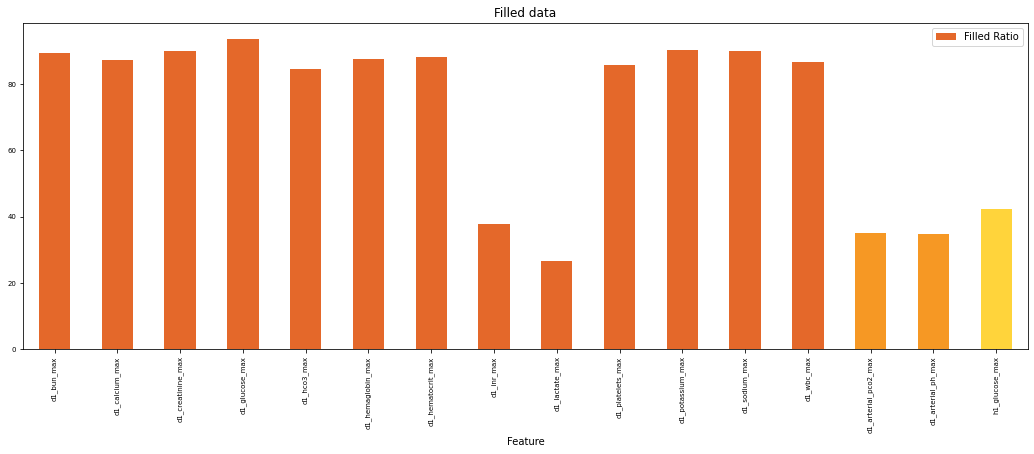

In [49]:
missingData(df_labs_)

In [50]:
df_labs_.replace('?',np.NaN,inplace=True)
imp=SimpleImputer(missing_values=np.NaN, strategy='median')
df_labs =pd.DataFrame(imp.fit_transform(df_labs_))
df_labs.columns=df_labs_.columns
df_labs.index=df_labs_.index

In [51]:
len(df_labs.columns)

16

In [52]:
missingData(df_labs)

(130157, 16)
There are no missing values


""


In [53]:
df_labs

,d1_bun_max,d1_calcium_max,d1_creatinine_max,d1_glucose_max,d1_hco3_max,d1_hemaglobin_max,d1_hematocrit_max,d1_inr_max,d1_lactate_max,d1_platelets_max,d1_potassium_max,d1_sodium_max,d1_wbc_max,d1_arterial_pco2_max,d1_arterial_ph_max,h1_glucose_max
0,31.0,8.5,2.51,168.0,19.0,8.9,27.4,1.30,1.3,233.0,4.0,136.0,14.1,42.9,7.390,140.0
1,11.0,8.6,0.71,145.0,27.0,11.3,36.9,1.30,3.5,557.0,4.2,145.0,23.3,37.0,7.450,145.0
2,19.0,8.4,1.00,150.0,24.0,11.4,34.5,1.30,1.9,194.0,4.2,139.0,11.1,42.9,7.390,140.0
3,19.0,8.4,1.00,185.0,24.0,11.6,34.0,1.60,1.9,198.0,5.0,139.0,9.0,37.0,7.440,140.0
4,19.0,8.4,1.00,150.0,24.0,11.4,34.5,1.30,1.9,194.0,4.2,139.0,11.1,42.9,7.390,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,19.0,8.4,1.00,150.0,24.0,11.4,34.5,1.30,1.9,194.0,4.2,139.0,11.1,42.9,7.390,140.0
130153,32.0,9.0,1.07,139.0,27.0,13.6,39.0,1.27,1.9,132.0,3.6,140.0,10.4,42.9,7.390,140.0
130154,31.0,8.1,2.65,346.0,26.0,11.0,33.0,1.14,9.8,233.0,4.4,142.0,41.8,44.0,7.614,140.0
130155,45.0,6.4,2.21,156.0,20.0,10.9,33.0,1.30,1.3,183.0,5.7,141.0,15.3,42.9,7.390,140.0


In [54]:
for col in LABS_COLUMNS_TO_INCLUDE:
    print(df_labs[col][imputeValues[col]])

2     19.0
3     19.0
4     19.0
12    19.0
18    19.0
Name: d1_bun_max, dtype: float64
2     8.4
3     8.4
4     8.4
12    8.4
18    8.4
Name: d1_calcium_max, dtype: float64
2     1.0
3     1.0
4     1.0
12    1.0
18    1.0
Name: d1_creatinine_max, dtype: float64
2     150.0
4     150.0
50    150.0
54    150.0
59    150.0
Name: d1_glucose_max, dtype: float64
2     24.0
3     24.0
4     24.0
12    24.0
18    24.0
Name: d1_hco3_max, dtype: float64
2     11.4
4     11.4
11    11.4
20    11.4
54    11.4
Name: d1_hemaglobin_max, dtype: float64
2     34.5
4     34.5
11    34.5
20    34.5
54    34.5
Name: d1_hematocrit_max, dtype: float64
0    1.3
2    1.3
4    1.3
6    1.3
7    1.3
Name: d1_inr_max, dtype: float64
2    1.9
3    1.9
4    1.9
5    1.9
6    1.9
Name: d1_lactate_max, dtype: float64
2     194.0
4     194.0
11    194.0
20    194.0
33    194.0
Name: d1_platelets_max, dtype: float64
2     4.2
4     4.2
12    4.2
20    4.2
50    4.2
Name: d1_potassium_max, dtype: float64
2     139.0

## 5. vitals - non-bp
- max/min - d1/h1: heartrate, resprate, spo2, temp 16 columns

**STRATEGY**

- Remove the rows where a single vital measurement is also not present(excluding BP)- 168 such records
- Treating the h1 empty columns by imputing with data from d1(day-24 hours) and vice versa

In [55]:
VITALS_BP_COLUMNS_TO_INCLUDE = [
        'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 
        'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 
        'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
        'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min', 'd1_sysbp_max', 'd1_sysbp_min', 
        'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
        'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min', 'h1_diasbp_max', 'h1_diasbp_min', 
        'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_mbp_max', 'h1_mbp_min',
        'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min', 
        'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min']

VITALS_NONBP_COLUMNS_TO_INCLUDE = [
        'd1_heartrate_max', 'd1_heartrate_min', 'd1_resprate_max', 'd1_resprate_min', 
        'd1_spo2_max', 'd1_spo2_min', 'd1_temp_max', 'd1_temp_min', 
        'h1_heartrate_max', 'h1_heartrate_min', 'h1_resprate_max', 'h1_resprate_min', 
        'h1_spo2_max', 'h1_spo2_min', 'h1_temp_max', 'h1_temp_min']

In [56]:
print(len(VITALS_BP_COLUMNS_TO_INCLUDE), len(VITALS_NONBP_COLUMNS_TO_INCLUDE))

36 16


In [57]:
df_vitals_nonbp_ = df[VITALS_NONBP_COLUMNS_TO_INCLUDE]

<AxesSubplot:>

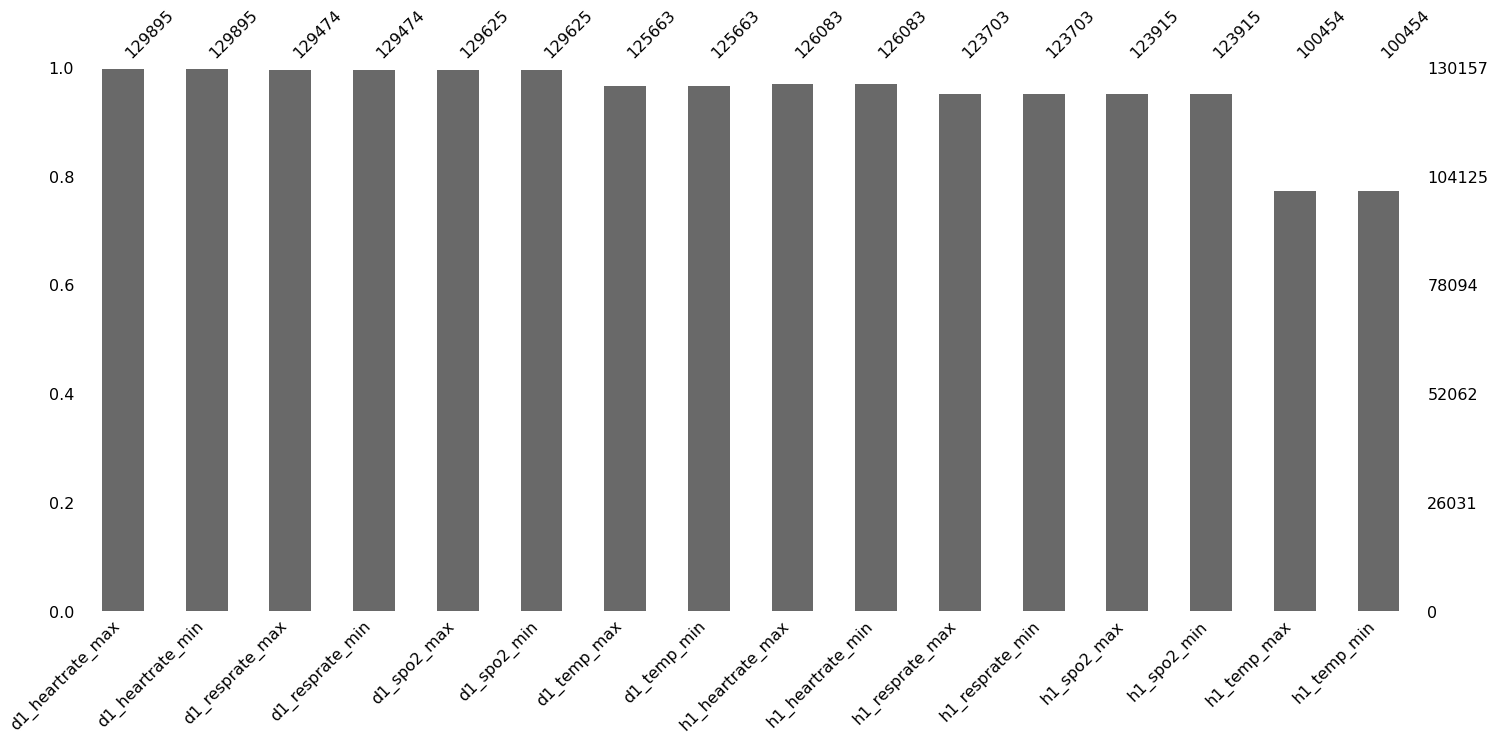

In [58]:
msno.bar(df_vitals_nonbp_)

In [59]:
print(f"Before Imputation, Count of rows with atleast 1 NaN: {nanRows(df_vitals_nonbp_)}")

Before Imputation, Count of rows with atleast 1 NaN: 33786, 25.96%


In [60]:
def updateCol1ByCol2(df, col1, col2):
    print(f"Before imputation: {col1}: {df[col1].isnull().sum()} | {col2}: {df[col2].isnull().sum()} ")
    df.loc[df[col1].isnull(),col1] = df[col2]
    df.loc[df[col2].isnull(),col2] = df[col1]
    print(f"After imputation: {col1}: {df[col1].isnull().sum()} | {col2}: {df[col2].isnull().sum()} ")
    return df
    


In [61]:
# Treating the h1 empty columns by imputing with data from d1(day-24 hours)
df_vitals_nonbp_ = updateCol1ByCol2(df_vitals_nonbp_, 'h1_temp_max', 'd1_temp_max')
df_vitals_nonbp_ = updateCol1ByCol2(df_vitals_nonbp_, 'h1_temp_min', 'd1_temp_min')
df_vitals_nonbp_ = updateCol1ByCol2(df_vitals_nonbp_, 'h1_spo2_max', 'd1_spo2_max')
df_vitals_nonbp_ = updateCol1ByCol2(df_vitals_nonbp_, 'h1_spo2_min', 'd1_spo2_min')
df_vitals_nonbp_ = updateCol1ByCol2(df_vitals_nonbp_, 'h1_heartrate_max', 'd1_heartrate_max')
df_vitals_nonbp_ = updateCol1ByCol2(df_vitals_nonbp_, 'h1_heartrate_min', 'd1_heartrate_min')
df_vitals_nonbp_ = updateCol1ByCol2(df_vitals_nonbp_, 'h1_resprate_max', 'd1_resprate_max')
df_vitals_nonbp_ = updateCol1ByCol2(df_vitals_nonbp_, 'h1_resprate_min', 'd1_resprate_min')


Before imputation: h1_temp_max: 29703 | d1_temp_max: 4494 
After imputation: h1_temp_max: 4494 | d1_temp_max: 4494 
Before imputation: h1_temp_min: 29703 | d1_temp_min: 4494 
After imputation: h1_temp_min: 4494 | d1_temp_min: 4494 
Before imputation: h1_spo2_max: 6242 | d1_spo2_max: 532 
After imputation: h1_spo2_max: 532 | d1_spo2_max: 532 
Before imputation: h1_spo2_min: 6242 | d1_spo2_min: 532 
After imputation: h1_spo2_min: 532 | d1_spo2_min: 532 
Before imputation: h1_heartrate_max: 4074 | d1_heartrate_max: 262 
After imputation: h1_heartrate_max: 262 | d1_heartrate_max: 262 
Before imputation: h1_heartrate_min: 4074 | d1_heartrate_min: 262 
After imputation: h1_heartrate_min: 262 | d1_heartrate_min: 262 
Before imputation: h1_resprate_max: 6454 | d1_resprate_max: 683 
After imputation: h1_resprate_max: 683 | d1_resprate_max: 683 
Before imputation: h1_resprate_min: 6454 | d1_resprate_min: 683 
After imputation: h1_resprate_min: 683 | d1_resprate_min: 683 


Wherever d1 is missing h1 is also missing

<AxesSubplot:>

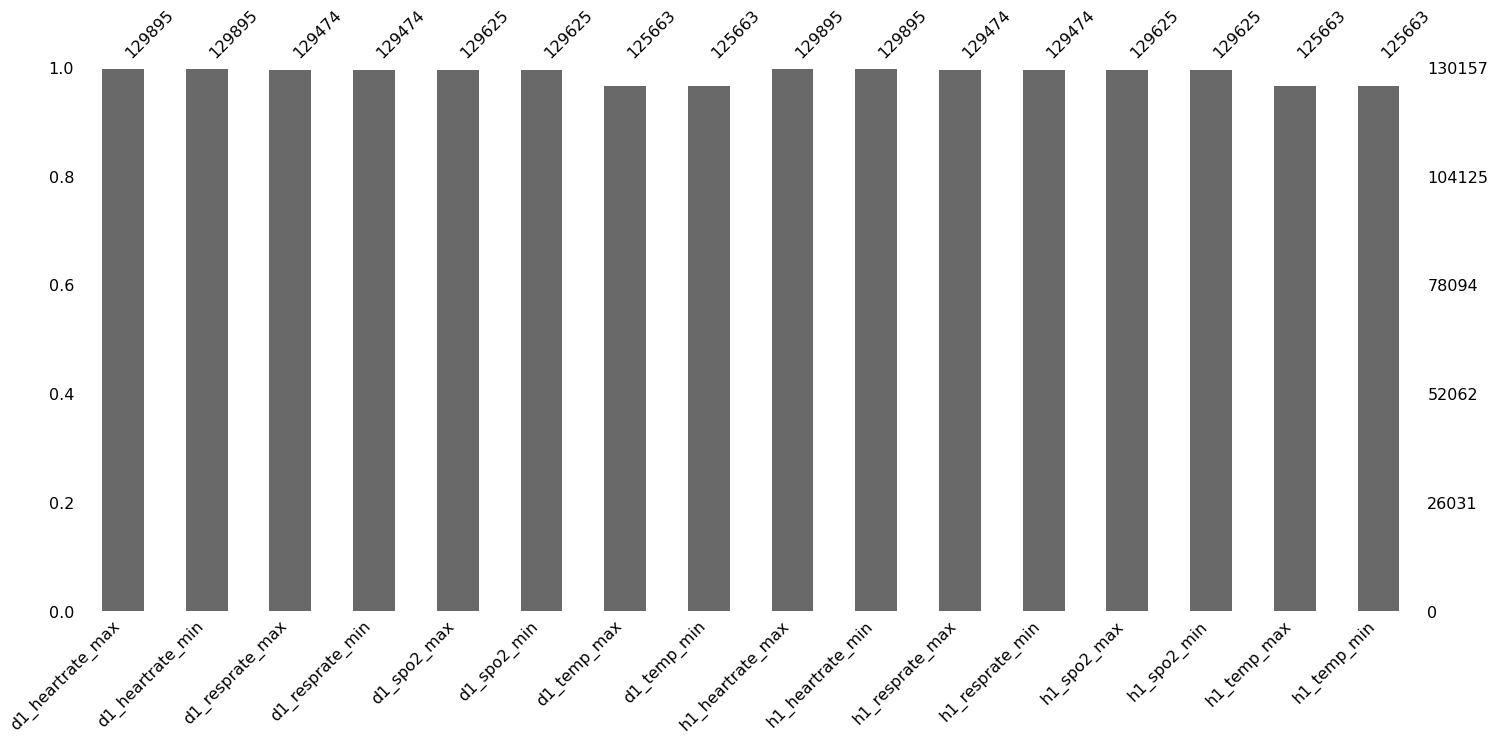

In [62]:
msno.bar(df_vitals_nonbp_)

In [63]:
print(f"After Imputation, Count of rows with atleast 1 NaN: {nanRows(df_vitals_nonbp_)}")

After Imputation, Count of rows with atleast 1 NaN: 5196, 3.99%


Remove these rows?

## 6. vitals - bp 
- diasbp/mbp/sysbp - invasive/non-invasive/general - max-min - d1/h1: Reduce 36 --> 12 columns

**STRATEGY**

- IMPUTE non-invasive with General and invasive with non-invasive
- IMPUTE the h1 empty columns with data from d1(day-24 hours) and vice versa
- DROP non-invasive and general

In [64]:
df_vitals_bp_ = df[VITALS_BP_COLUMNS_TO_INCLUDE]

<AxesSubplot:>

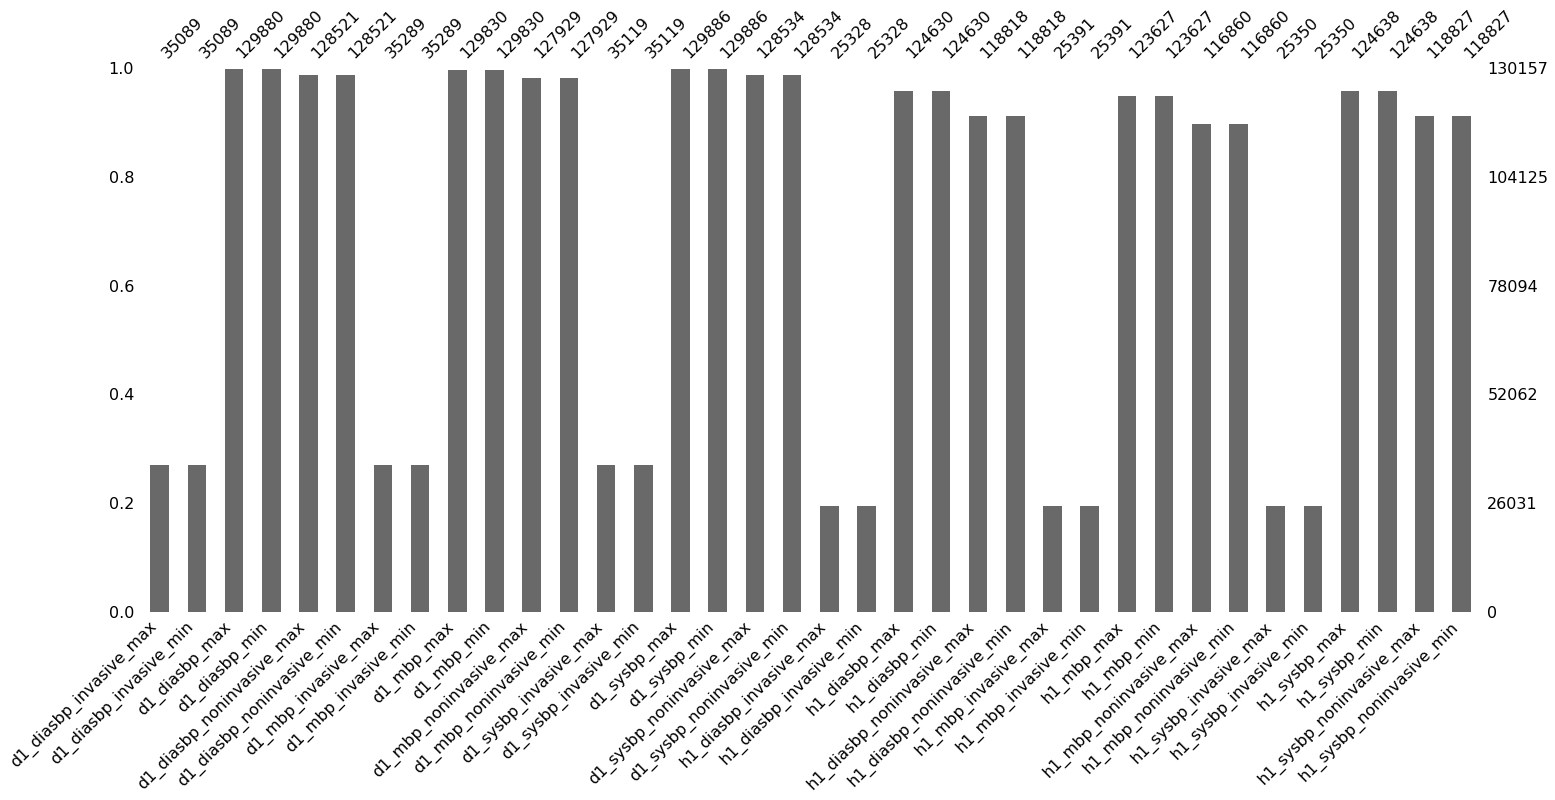

In [65]:
msno.bar(df_vitals_bp_)

In [66]:
print(f"Before Imputation, Count of rows with atleast 1 NaN: {nanRows(df_vitals_bp_)}")

Before Imputation, Count of rows with atleast 1 NaN: 111934, 86.00%


In [67]:
def imputeInvNoninvGen(df, invCol, nonInvCol, genCol):
    print(f"Before imputation: {invCol}: {df[invCol].isnull().sum()} | {nonInvCol}: {df[nonInvCol].isnull().sum()} | {genCol}: {df[genCol].isnull().sum()}")
    #print(df.columns)
    df.loc[df[nonInvCol].isnull(),nonInvCol] = df[genCol]
    df.loc[df[invCol].isnull(),invCol] = df[nonInvCol]
    df_ = df.drop(columns=[nonInvCol,genCol])
    #print(df_.columns)
    print(f"After imputation: {invCol}: {df[invCol].isnull().sum()} | {nonInvCol}: {df[nonInvCol].isnull().sum()} | {genCol}: {df[genCol].isnull().sum()}")
    return df_

In [68]:
df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'd1_diasbp_invasive_max', 'd1_diasbp_noninvasive_max', 'd1_diasbp_max' )
df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'd1_diasbp_invasive_min', 'd1_diasbp_noninvasive_min', 'd1_diasbp_min' )
df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'h1_diasbp_invasive_max', 'h1_diasbp_noninvasive_max', 'h1_diasbp_max' )
df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'h1_diasbp_invasive_min', 'h1_diasbp_noninvasive_min', 'h1_diasbp_min' )

df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'd1_mbp_invasive_max', 'd1_mbp_noninvasive_max', 'd1_mbp_max' )
df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'd1_mbp_invasive_min', 'd1_mbp_noninvasive_min', 'd1_mbp_min' )
df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'h1_mbp_invasive_max', 'h1_mbp_noninvasive_max', 'h1_mbp_max' )
df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'h1_mbp_invasive_min', 'h1_mbp_noninvasive_min', 'h1_mbp_min' )

df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'd1_sysbp_invasive_max', 'd1_sysbp_noninvasive_max', 'd1_sysbp_max' )
df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'd1_sysbp_invasive_min', 'd1_sysbp_noninvasive_min', 'd1_sysbp_min' )
df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'h1_sysbp_invasive_max', 'h1_sysbp_noninvasive_max', 'h1_sysbp_max' )
df_vitals_bp_ = imputeInvNoninvGen(df_vitals_bp_, 'h1_sysbp_invasive_min', 'h1_sysbp_noninvasive_min', 'h1_sysbp_min' )


Before imputation: d1_diasbp_invasive_max: 95068 | d1_diasbp_noninvasive_max: 1636 | d1_diasbp_max: 277
After imputation: d1_diasbp_invasive_max: 277 | d1_diasbp_noninvasive_max: 277 | d1_diasbp_max: 277
Before imputation: d1_diasbp_invasive_min: 95068 | d1_diasbp_noninvasive_min: 1636 | d1_diasbp_min: 277
After imputation: d1_diasbp_invasive_min: 277 | d1_diasbp_noninvasive_min: 277 | d1_diasbp_min: 277
Before imputation: h1_diasbp_invasive_max: 104829 | h1_diasbp_noninvasive_max: 11339 | h1_diasbp_max: 5527
After imputation: h1_diasbp_invasive_max: 5527 | h1_diasbp_noninvasive_max: 5527 | h1_diasbp_max: 5527
Before imputation: h1_diasbp_invasive_min: 104829 | h1_diasbp_noninvasive_min: 11339 | h1_diasbp_min: 5527
After imputation: h1_diasbp_invasive_min: 5527 | h1_diasbp_noninvasive_min: 5527 | h1_diasbp_min: 5527
Before imputation: d1_mbp_invasive_max: 94868 | d1_mbp_noninvasive_max: 2228 | d1_mbp_max: 327
After imputation: d1_mbp_invasive_max: 327 | d1_mbp_noninvasive_max: 327 | d1

In [69]:
print(f"After Imputation, Count of rows with atleast 1 NaN: {nanRows(df_vitals_bp_)}")

After Imputation, Count of rows with atleast 1 NaN: 6974, 5.36%


In [70]:
df_vitals_bp_ = updateCol1ByCol2(df_vitals_bp_, 'h1_diasbp_invasive_max', 'd1_diasbp_invasive_max')
df_vitals_bp_ = updateCol1ByCol2(df_vitals_bp_, 'h1_diasbp_invasive_min', 'd1_diasbp_invasive_min')
df_vitals_bp_ = updateCol1ByCol2(df_vitals_bp_, 'h1_mbp_invasive_max', 'd1_mbp_invasive_max')
df_vitals_bp_ = updateCol1ByCol2(df_vitals_bp_, 'h1_mbp_invasive_min', 'd1_mbp_invasive_min')
df_vitals_bp_ = updateCol1ByCol2(df_vitals_bp_, 'h1_sysbp_invasive_max', 'd1_sysbp_invasive_max')
df_vitals_bp_ = updateCol1ByCol2(df_vitals_bp_, 'h1_sysbp_invasive_min', 'd1_sysbp_invasive_min')

Before imputation: h1_diasbp_invasive_max: 5527 | d1_diasbp_invasive_max: 277 
After imputation: h1_diasbp_invasive_max: 277 | d1_diasbp_invasive_max: 277 
Before imputation: h1_diasbp_invasive_min: 5527 | d1_diasbp_invasive_min: 277 
After imputation: h1_diasbp_invasive_min: 277 | d1_diasbp_invasive_min: 277 
Before imputation: h1_mbp_invasive_max: 6530 | d1_mbp_invasive_max: 327 
After imputation: h1_mbp_invasive_max: 327 | d1_mbp_invasive_max: 327 
Before imputation: h1_mbp_invasive_min: 6530 | d1_mbp_invasive_min: 327 
After imputation: h1_mbp_invasive_min: 327 | d1_mbp_invasive_min: 327 
Before imputation: h1_sysbp_invasive_max: 5519 | d1_sysbp_invasive_max: 271 
After imputation: h1_sysbp_invasive_max: 271 | d1_sysbp_invasive_max: 271 
Before imputation: h1_sysbp_invasive_min: 5519 | d1_sysbp_invasive_min: 271 
After imputation: h1_sysbp_invasive_min: 271 | d1_sysbp_invasive_min: 271 


<AxesSubplot:>

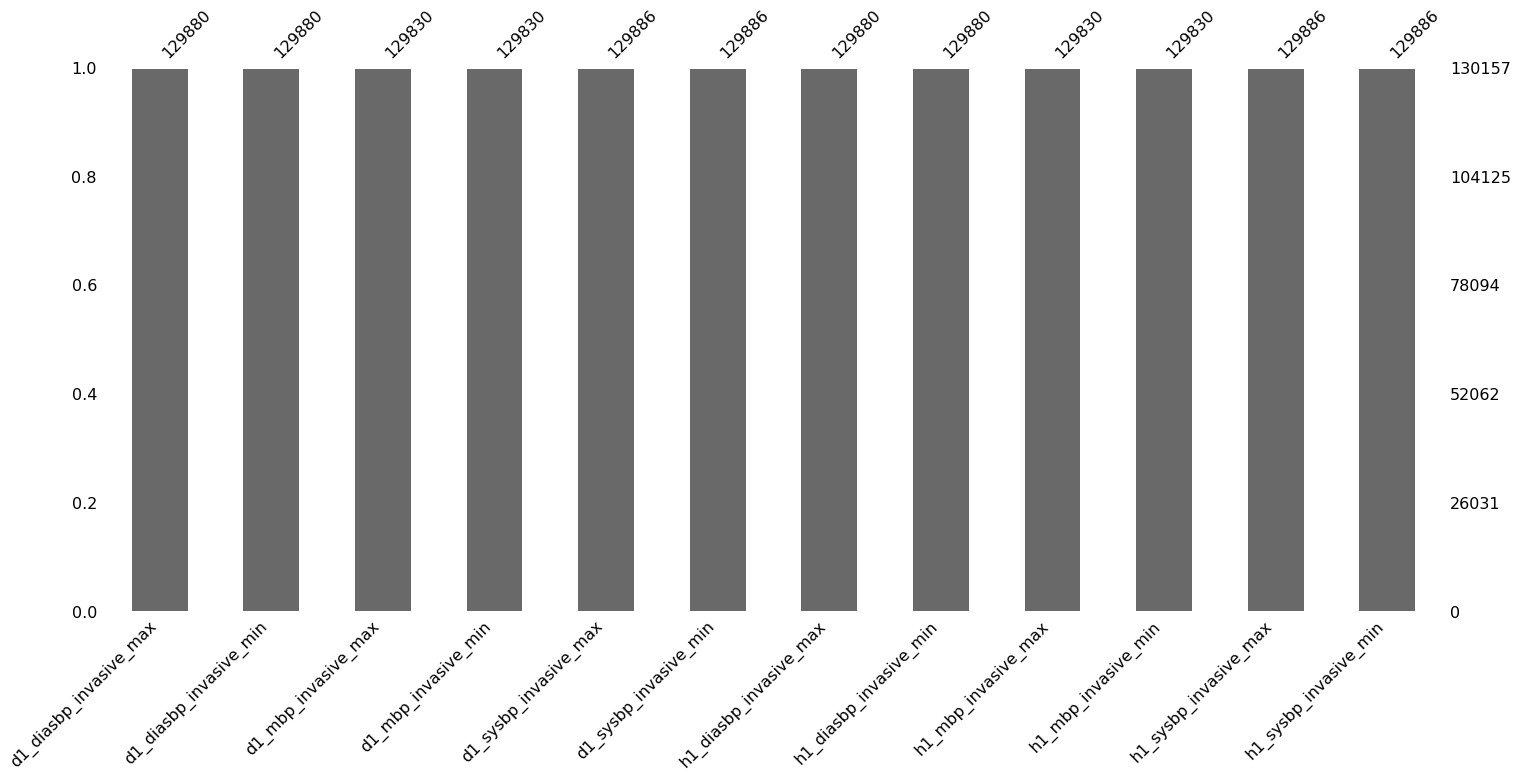

In [71]:
msno.bar(df_vitals_bp_)

In [72]:
print(f"After Imputation-2, Count of rows with atleast 1 NaN: {nanRows(df_vitals_bp_)}")

After Imputation-2, Count of rows with atleast 1 NaN: 362, 0.28%


In [73]:
df_vitals = df_vitals_nonbp_
df_vitals[df_vitals_bp_.columns] = df_vitals_bp_
print(df_vitals.shape, df_vitals.columns)

(130157, 28) Index(['d1_heartrate_max', 'd1_heartrate_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_temp_max',
       'd1_temp_min', 'h1_heartrate_max', 'h1_heartrate_min',
       'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min',
       'h1_temp_max', 'h1_temp_min', 'd1_diasbp_invasive_max',
       'd1_diasbp_invasive_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min',
       'd1_sysbp_invasive_max', 'd1_sysbp_invasive_min',
       'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min',
       'h1_mbp_invasive_max', 'h1_mbp_invasive_min', 'h1_sysbp_invasive_max',
       'h1_sysbp_invasive_min'],
      dtype='object')


In [74]:
df_new = df_demo
df_new[df_labs.columns] = df_labs
df_new[df_vitals.columns] = df_vitals

In [75]:
df_new.shape

(130157, 59)

In [76]:
df_new.columns

Index(['age', 'height', 'weight', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'gender_M', 'elective_surgery',
       'hospital_admit_source', 'icu_admit_source', 'icu_stay_type',
       'icu_type', 'pre_icu_los_days', 'd1_bun_max', 'd1_calcium_max',
       'd1_creatinine_max', 'd1_glucose_max', 'd1_hco3_max',
       'd1_hemaglobin_max', 'd1_hematocrit_max', 'd1_inr_max',
       'd1_lactate_max', 'd1_platelets_max', 'd1_potassium_max',
       'd1_sodium_max', 'd1_wbc_max', 'd1_arterial_pco2_max',
       'd1_arterial_ph_max', 'h1_glucose_max', 'd1_heartrate_max',
       'd1_heartrate_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max',
       'd1_spo2_min', 'd1_temp_max', 'd1_temp_min', 'h1_heartrate_max',
       'h1_heartrate_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max',
       'h1_spo2_min', 'h1_temp_max', 'h1_temp_min', 'd1_diasbp_invasive_max',
       'd1_diasbp_invasive_min',

In [78]:
df_new[0:10]

,age,height,weight,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gender_M,elective_surgery,...,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min
0,68.0,180.3,73.90,0,1,0,0,0,1,0,...,66.0,40.0,122.0,64.0,68.0,63.0,86.0,85.0,131.0,115.0
1,77.0,160.0,70.20,0,1,0,0,0,0,0,...,120.0,38.0,159.0,67.0,61.0,48.0,85.0,57.0,95.0,71.0
2,25.0,172.7,95.30,0,1,0,0,0,0,0,...,102.0,68.0,148.0,105.0,88.0,58.0,91.0,83.0,148.0,124.0
3,81.0,165.1,61.70,0,1,0,0,0,0,1,...,92.0,52.0,164.0,78.0,62.0,44.0,92.0,71.0,136.0,106.0
4,19.0,188.0,88.95,0,1,0,0,0,1,0,...,104.0,90.0,147.0,120.0,99.0,68.0,104.0,92.0,130.0,120.0
5,67.0,190.5,100.00,0,1,0,0,0,1,0,...,127.0,80.0,173.0,107.0,89.0,89.0,111.0,111.0,143.0,143.0
6,59.0,165.1,156.60,0,1,0,0,0,0,0,...,138.0,84.0,191.0,116.0,107.0,79.0,138.0,115.0,191.0,163.0
7,70.0,165.0,105.95,0,1,0,0,0,1,0,...,114.0,60.0,147.0,71.0,74.0,55.0,88.0,60.0,119.0,106.0
8,45.0,170.2,57.60,0,1,0,0,0,1,0,...,72.0,66.0,94.0,72.0,64.0,52.0,72.0,66.0,94.0,72.0
9,50.0,175.3,79.00,0,0,1,0,0,1,0,...,92.0,73.0,126.0,103.0,73.0,62.0,92.0,78.0,126.0,106.0


In [79]:
cols = df_new.columns[df_new.dtypes.eq('object')]
print(len(cols), cols)

6 Index(['elective_surgery', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'pre_icu_los_days'],
      dtype='object')


In [80]:
df_new[cols] = df_new[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [81]:
df_new.columns

Index(['age', 'height', 'weight', 'ethnicity_Asian', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'ethnicity_Native American',
       'ethnicity_Other/Unknown', 'gender_M', 'elective_surgery',
       'hospital_admit_source', 'icu_admit_source', 'icu_stay_type',
       'icu_type', 'pre_icu_los_days', 'd1_bun_max', 'd1_calcium_max',
       'd1_creatinine_max', 'd1_glucose_max', 'd1_hco3_max',
       'd1_hemaglobin_max', 'd1_hematocrit_max', 'd1_inr_max',
       'd1_lactate_max', 'd1_platelets_max', 'd1_potassium_max',
       'd1_sodium_max', 'd1_wbc_max', 'd1_arterial_pco2_max',
       'd1_arterial_ph_max', 'h1_glucose_max', 'd1_heartrate_max',
       'd1_heartrate_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max',
       'd1_spo2_min', 'd1_temp_max', 'd1_temp_min', 'h1_heartrate_max',
       'h1_heartrate_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max',
       'h1_spo2_min', 'h1_temp_max', 'h1_temp_min', 'd1_diasbp_invasive_max',
       'd1_diasbp_invasive_min',

## Train the model

In [82]:
compute_roc_auc(df_new, target)

[15:04:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train auc 0.8125350805419144
test auc 0.678716302039512
Time taken: 0:00:25.484883


# Submission

In [ ]:
'''
my_submission = pd.DataFrame()
my_submission['encounter_id'] = test_ids
my_submission['diabetes_mellitus'] = test_pred
my_submission.to_csv('My_submission.csv', index=False)
'''